In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt  

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm  

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Ensure TensorFlow runs on GPU (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is available and configured.")

GPU is available and configured.


In [4]:
data_dir = r"C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\BrainTumour2"
# Resize images to 224x224 to match EfficientNetB0
img_size = (224, 224)
batch_size = 16  # Batch size for training

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to 0-1
    rotation_range=20,       # Rotate images randomly
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    validation_split=0.2     # 80% training, 20% validation
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training'          # Training data
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'       # Validation data
)

Found 5619 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.


Class labels: {'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}


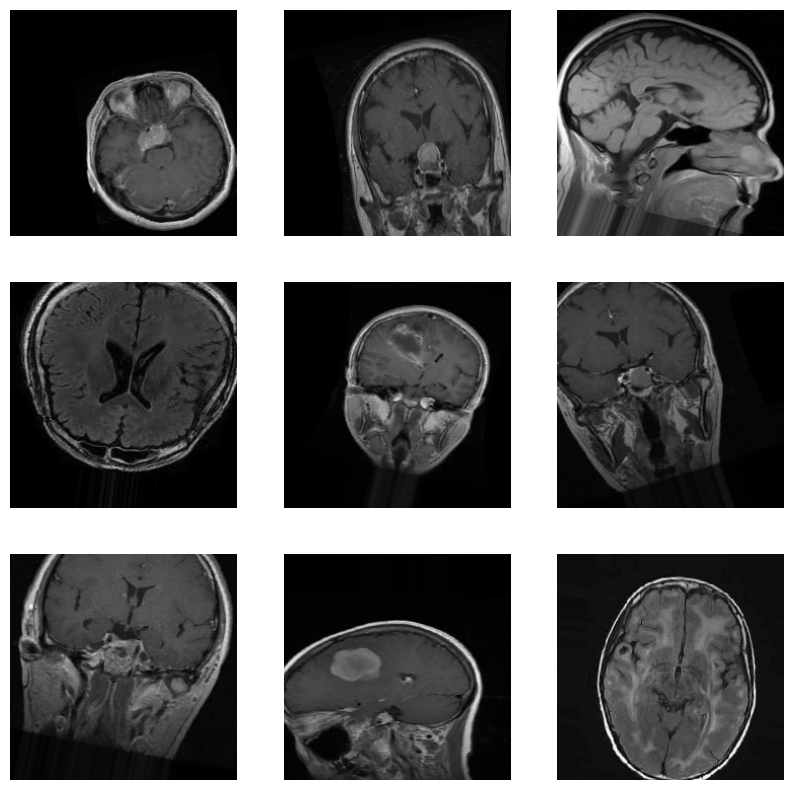

In [7]:
print("Class labels:", train_generator.class_indices)

# Visualizing the first 9 images from the training data
def plot_images(generator):
    images, labels = next(generator)  # Get the first batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis("off")  # Hide axes
    plt.show()

# Display a few sample images
plot_images(train_generator)

In [8]:
labels = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Preparing the data (Resizing and Normalizing)
X_train = []
y_train = []
image_size = 150  # Resize all images to 150x150
for i in labels:
    folderPath = os.path.join(r"C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\BrainTumour2", i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train) / 255.0  # Normalize images
y_train = np.array(y_train)

100%|██████████| 1757/1757 [00:19<00:00, 92.39it/s] 


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# Convert labels to numerical indices and apply one-hot encoding
y_train = [labels.index(i) for i in y_train]
y_test = [labels.index(i) for i in y_test]

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load EfficientNetB0 model without the top layer
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Make the last 20 layers trainable
for layer in effnet.layers[-20:]:
    layer.trainable = True

# Add custom layers
x = effnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Create the final model
model = tf.keras.models.Model(inputs=effnet.input, outputs=x)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()  # Display model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  


 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']          
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 32)   864         ['stem_conv_pad[0][0]']          
                                                                                                  
 stem_bn (

In [13]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [14]:
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
 21/198 [==>...........................] - ETA: 41s - loss: 1.4081 - accuracy: 0.3348

ResourceExhaustedError: Graph execution error:

Detected at node 'Adam/gradients/Sigmoid' defined at (most recent call last):
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\karti\AppData\Local\Temp\ipykernel_16804\2265144837.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'Adam/gradients/Sigmoid'
failed to allocate memory
	 [[{{node Adam/gradients/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18267]

In [ ]:
# Evaluating the Performance of the Model on the Test Set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=labels)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Drawing Process Graphs
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()